#### Checklist
        
    Analytic question 3
        line plot client contacts per month
        +pie chart contact type
        histogram of duration by age and balance

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
%matplotlib inline

In [2]:
bank_marketing = pd.read_csv('bank-full.csv', sep=';')
bank_marketing.index.name = 'client'

# Portuguese Banking Institution Database For Long-Term Deposit Product Marketing Campaign

## Release

This dataset lists bank clients of a Portuguese banking institution on whom they conducted a direct marketing campaign for a savings deposit product. It was originally released in 2011 by Moro et al., a machine learning research team, who revised it with commensurate macroeconomic data in 2014. The team collected the information directly from the enterprise's databases, though 17 of the 59 is only made available to the public. The information represents the results of a direct marketing campgain conducted by the bank and was collected via phone calls to 45211 clients dated from May 2008 to November 2010.

## Datasets and Attributes

The UCI ML library hosts two datasets, each with a 10% sample used for the ML activity and a full version, which I used here. As stated above, one of these sets was modified and finalized in 2014 to include macroeconomic data, 5 attributes:
16.quarterly employment variation rate
17.monthly consumer price index
18.monthly consumer confidence index
19.daily euribor 3 month rate
20.quarterly total of employed Portuguese.

I worked with the original set because of the claim of no missing values. There are a total of 17 attributes collected for each client:
1.age
2.job: category
3.martital: status
4.education
5.default: possesses credit in default
6.housing: loan?
7.personal: loan?
8.contact: method used to engage client
9.month of last client engagement
10.day of last client engagement
11.duration of last client engagement
12.campaign: # of engagements during the period of the campaign
13.pdays: days passed between engagement during prior campaign and engagement this campaign
14.previous: number of engagements during last campaign for this client
15.poutcome: outcome of previous marketing campaign for this client

The header data can be seen below.

In [3]:
bank_marketing.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
client,,,,,,,,,,,,,,,,,
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Analytic Questions

## 1) Who are the bank clients? How do their demographics vary by age, occupation, marital status, education, and housing?

We first will get a handle on this data by exploring the subjects of the marketing campaign. This data set gave some basic demography information in the context of financial services from this major European banking institution. Let's look at the ages involved.

In [4]:
print('The minimum age is {} and the maximum is {}'.format(min(
      bank_marketing.age), max(bank_marketing.age)))

The minimum age is 18 and the maximum is 95


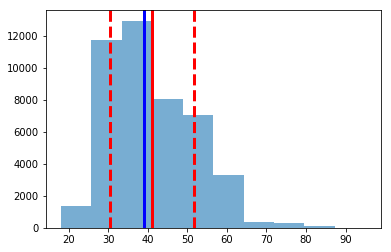

In [5]:
# histogram of ages
plt.hist(bank_marketing.age, alpha=.6)
plt.axvline(bank_marketing.age.mean(), color='r', linestyle='solid', linewidth=3)
plt.axvline(bank_marketing.age.median(), color='b', linestyle='solid', linewidth=3)
plt.axvline(bank_marketing.age.mean()+bank_marketing.age.std(), color='r', linestyle='dashed', linewidth=3)
plt.axvline(bank_marketing.age.mean()-bank_marketing.age.std(), color='r', linestyle='dashed', linewidth=3)
plt.show()

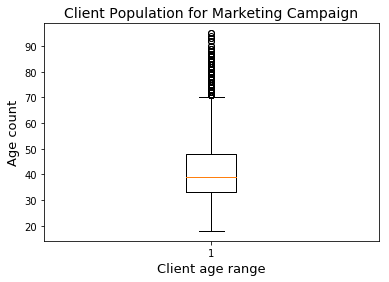

In [6]:
# Boxplot of ages to discover outliers
plt.boxplot(bank_marketing['age'])
plt.ylabel('Age count', fontsize=13)
plt.title('Client Population for Marketing Campaign', fontsize=14)
plt.xlabel('Client age range', fontsize=13)
plt.show()

These basic visuals of the population distribution show that there are enough datapoints beyond ~2 SD's (late 60s and above) to positively skew it.

There is a commonly reported figure by Western governments that the amounts of people living in old age has risen since last century, and this subset of the Portuguese population is reflecting this trend, despite any possible deviations these clients' socioeconomic attributes may have from the distributions reported by authorities.

####correct Eurostat, the EU's statistics department, reported in 2012 that Portugal's rate of 129.4 elderly per 100 is nearly double that of 1990's. This is a shared central tendancy amongst the 28 nations, and Portugal in 6th place is above average.

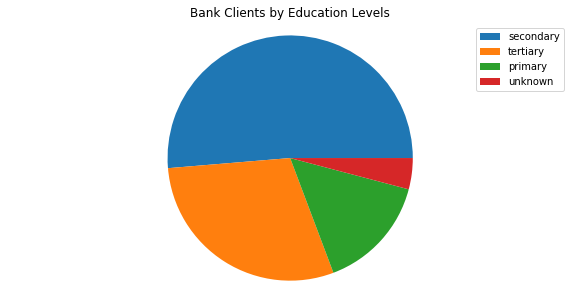

In [7]:
# pie chart of education
edu_counts = pd.DataFrame(bank_marketing.education.value_counts())
edu_counts
plt.figure(figsize=(10, 5))
plt.pie(edu_counts)
plt.axis('equal')
plt.title('Bank Clients by Education Levels')
plt.legend(edu_counts.index)
plt.show()

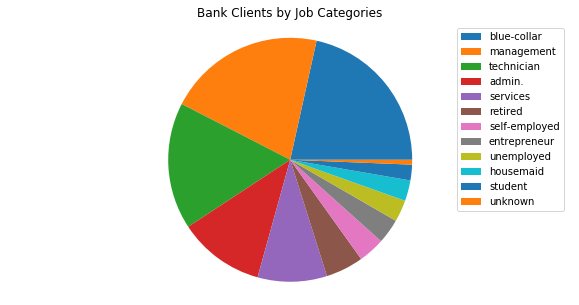

In [8]:
# pie chart of jobs
occu_counts = pd.DataFrame(bank_marketing.job.value_counts())
plt.figure(figsize=(10, 5))
plt.pie(occu_counts)
plt.axis('equal')
plt.title('Bank Clients by Job Categories')
plt.legend(occu_counts.index)
plt.show()

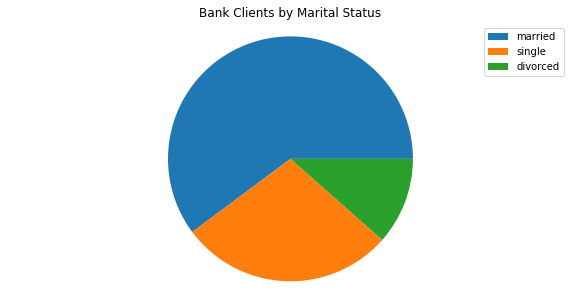

In [9]:
# pie chart of marital status
marital_counts = pd.DataFrame(bank_marketing.marital.value_counts())
plt.figure(figsize=(10, 5))
plt.pie(marital_counts)
plt.axis('equal')
plt.title('Bank Clients by Marital Status')
plt.legend(marital_counts.index)
plt.show()

The pie charts show that more than half of the clients were educated up to secondary school, work blue-collar or in management, and are married. 

I shall note that secondary school is more deliberately specialized in Portugal. The diplomas children are able to achieve by 18 are also geared toward vocational or artistic careers. It is not surprising, then, to see that blue-collar, management, and technicians represent nearly 2/3rds of this data set ## ffafdsaf remind yourself of how the banks chose these people!

Eurostat also measures divorces and reported in 2011 that Portugal's divorces per 100 marriages skyrocketed from about 7 to 74, yet they were easily in the bottom 5 as measured in 1981. There are no explanations provided in the report I found, and I surely have suspicion of confounding variables. On the brighter side, Banco Portugal's clients may vary greatly from this statistic.

## 2) Which clients did and didn't subscribe to the term deposit product? How do they vary by financial attributes?

Ages subscription histogram yes/no
        +pie charts for occupation, marital status, education yes/no
        +histogram by balance ranges yes/no
        qq plots ages and balance

In [10]:
print('The amount of people surveyed who subsribed to the long-term'
      'bank deposit product is {}% as of Nov 2010'.format(np.multiply(100,1 - np.divide(
      bank_marketing.y.describe().freq,bank_marketing.y.count()))))

The amount of people surveyed who subsribed to the long-termbank deposit product is 11.698480458295546% as of Nov 2010


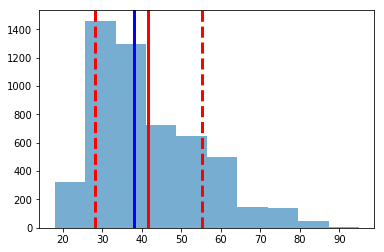

In [11]:
# Ages subscription histogram yes
plt.hist(bank_marketing.groupby(['y']).get_group('yes')['age'], alpha=.6)
plt.axvline(bank_marketing.groupby(['y']).get_group('yes')['age'].mean(), color='r', linestyle='solid', linewidth=3)
plt.axvline(bank_marketing.groupby(['y']).get_group('yes')['age'].median(), color='b', linestyle='solid', linewidth=3)
plt.axvline(bank_marketing.groupby(['y']).get_group('yes')['age'].mean()+bank_marketing.groupby(['y']).get_group('yes')['age'].std(), color='r', linestyle='dashed', linewidth=3)
plt.axvline(bank_marketing.groupby(['y']).get_group('yes')['age'].mean()-bank_marketing.groupby(['y']).get_group('yes')['age'].std(), color='r', linestyle='dashed', linewidth=3)
plt.show()

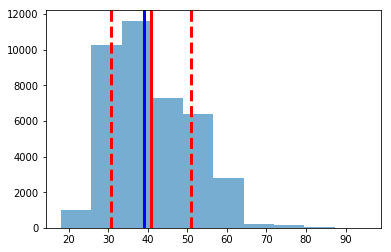

In [12]:
# Ages subscription histogram no
plt.hist(bank_marketing.groupby(['y']).get_group('no')['age'], alpha=.6)
plt.axvline(bank_marketing.groupby(['y']).get_group('no')['age'].mean(), color='r', linestyle='solid', linewidth=3)
plt.axvline(bank_marketing.groupby(['y']).get_group('no')['age'].median(), color='b', linestyle='solid', linewidth=3)
plt.axvline(bank_marketing.groupby(['y']).get_group('no')['age'].mean()+bank_marketing.groupby(['y']).get_group('no')['age'].std(), color='r', linestyle='dashed', linewidth=3)
plt.axvline(bank_marketing.groupby(['y']).get_group('no')['age'].mean()-bank_marketing.groupby(['y']).get_group('no')['age'].std(), color='r', linestyle='dashed', linewidth=3)
plt.show()

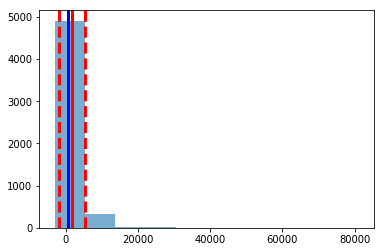

In [13]:
# histogram of balances yes
plt.hist(bank_marketing.groupby(['y']).get_group('yes')['balance'], alpha=.6)
plt.axvline(bank_marketing.groupby(['y']).get_group('yes')['balance'].mean(), color='r', linestyle='solid', linewidth=3)
plt.axvline(bank_marketing.groupby(['y']).get_group('yes')['balance'].median(), color='b', linestyle='solid', linewidth=3)
plt.axvline(bank_marketing.groupby(['y']).get_group('yes')['balance'].mean()+bank_marketing.groupby(['y']).get_group('yes')['balance'].std(), color='r', linestyle='dashed', linewidth=3)
plt.axvline(bank_marketing.groupby(['y']).get_group('yes')['balance'].mean()-bank_marketing.groupby(['y']).get_group('yes')['balance'].std(), color='r', linestyle='dashed', linewidth=3)
plt.show()

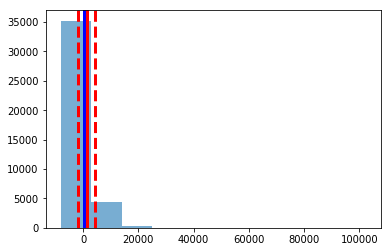

In [14]:
# histogram of balances no
plt.hist(bank_marketing.groupby(['y']).get_group('no')['balance'], alpha=.6)
plt.axvline(bank_marketing.groupby(['y']).get_group('no')['balance'].mean(), color='r', linestyle='solid', linewidth=3)
plt.axvline(bank_marketing.groupby(['y']).get_group('no')['balance'].median(), color='b', linestyle='solid', linewidth=3)
plt.axvline(bank_marketing.groupby(['y']).get_group('no')['balance'].mean()+bank_marketing.groupby(['y']).get_group('no')['balance'].std(), color='r', linestyle='dashed', linewidth=3)
plt.axvline(bank_marketing.groupby(['y']).get_group('no')['balance'].mean()-bank_marketing.groupby(['y']).get_group('no')['balance'].std(), color='r', linestyle='dashed', linewidth=3)
plt.show()

In [15]:
# QQ plots of subscribers/nonsubscribers balances and ages against normal
# distribution
age_yes = bank_marketing.groupby(['y']).get_group('yes').loc[:,'age'].values
age_no = bank_marketing.groupby(['y']).get_group('no').loc[:,'age'].values
balance_yes = bank_marketing.groupby(['y']).get_group('yes').loc[:,'balance'].values
balance_no = bank_marketing.groupby(['y']).get_group('no').loc[:,'balance'].values
norm_age_yes = np.random.normal(0, 1, len(age_yes))
norm_age_no = np.random.normal(0, 1, len(age_no))
norm_balance_yes = np.random.normal(0, 1, len(balance_yes))
norm_balance_no = np.random.normal(0, 1, len(balance_no))

39922


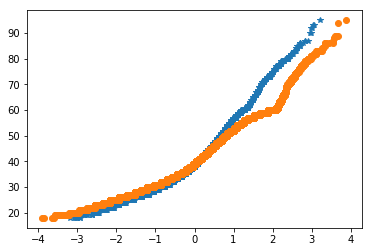

In [16]:
age_yes.sort()
age_no.sort()
balance_yes.sort()
balance_no.sort()
norm_age_yes.sort()
norm_age_no.sort()
norm_balance_yes.sort()
norm_balance_no.sort()
plt.plot(norm_age_yes, age_yes, '*')
plt.plot(norm_age_no, age_no, 'o')
plt.show()

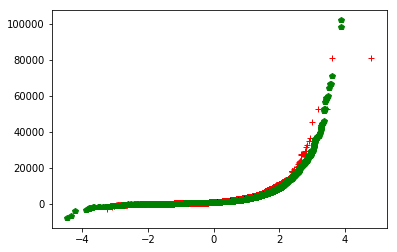

In [17]:
plt.plot(norm_balance_yes, balance_yes, '+', color='r')
plt.plot(norm_balance_no, balance_no, 'p', color='g')
plt.show()

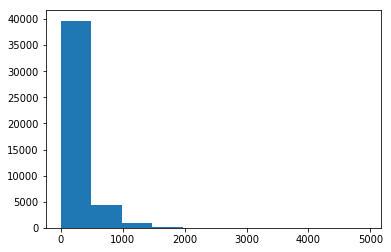

In [56]:
# histogram of total contact duration by age
plt.hist(bank_marketing['duration'])
#plt.axvline(bank_marketing.groupby(['age']).agg(np.sum)['duration'].mean(), color='r', linestyle='solid', linewidth=3)
#plt.axvline(bank_marketing.groupby(['age']).agg(np.sum)['duration'].median(), color='b', linestyle='solid', linewidth=3)
#plt.axvline(bank_marketing.groupby(['age']).agg(np.sum)['duration'].mean()+bank_marketing.groupby(['age']).agg(np.sum)['duration'].std(), color='r', linestyle='dashed', linewidth=3)
#plt.axvline(bank_marketing.groupby(['age']).agg(np.sum)['duration'].mean()-bank_marketing.groupby(['age']).agg(np.sum)['duration'].std(), color='r', linestyle='dashed', linewidth=3)
plt.show()

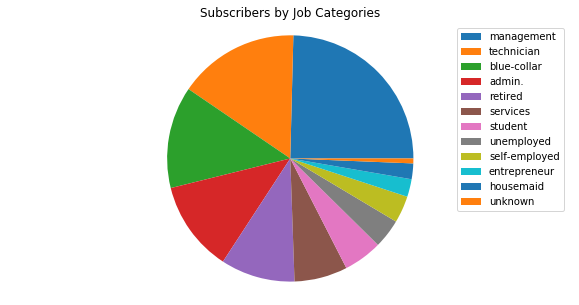

In [18]:
# pie chart of product subscribers by job category
buyer_occu_counts = pd.DataFrame(bank_marketing.loc[lambda df: df.y==
                    'yes','job'].value_counts())
plt.figure(figsize=(10, 5))
plt.pie(buyer_occu_counts)
plt.axis('equal')
plt.title('Subscribers by Job Categories')
plt.legend(buyer_occu_counts.index)
plt.show()

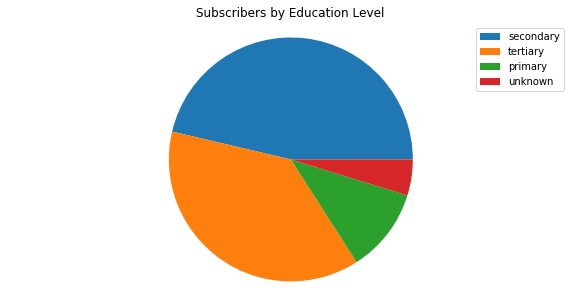

In [19]:
# pie chart of product subscribers by education level
buyer_edu_counts = pd.DataFrame(bank_marketing.loc[lambda df: df.y==
                    'yes','education'].value_counts())
plt.figure(figsize=(10, 5))
plt.pie(buyer_edu_counts)
plt.axis('equal')
plt.title('Subscribers by Education Level')
plt.legend(buyer_edu_counts.index)
plt.show()

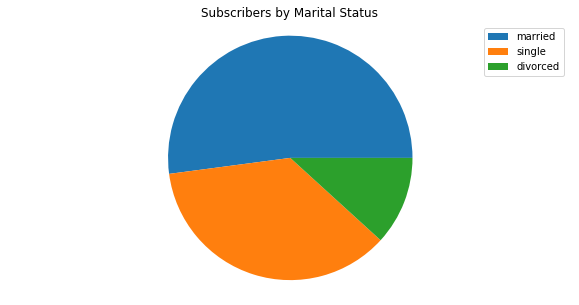

In [20]:
# pie chart of product subscribers by marital status
buyer_edu_counts = pd.DataFrame(bank_marketing.loc[lambda df: df.y==
                    'yes','marital'].value_counts())
pd.DataFrame(buyer_edu_counts)
plt.figure(figsize=(10, 5))
plt.pie(buyer_edu_counts)
plt.axis('equal')
plt.title('Subscribers by Marital Status')
plt.legend(buyer_edu_counts.index)
plt.show()

Additionally, each pie chart reveals a small, delightful insight for the bank. For the occupation pie chart, it is clear to me that the proportions barely moved a pixel. I recommend further study, because the implications of true similarity between these demographics sets the Banco on a bright, simple path in business intelligence and analytics.

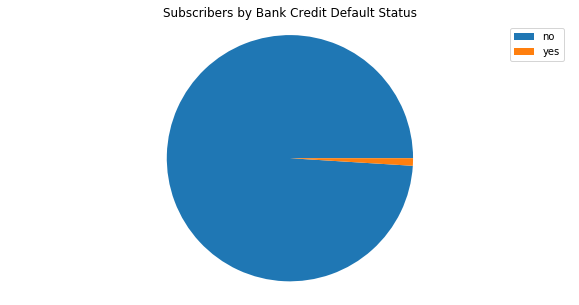

In [21]:
# pie chart of product subscribers by bank credit status.
buyer_def_counts = pd.DataFrame(bank_marketing.loc[lambda df: df.y==
                    'yes','default'].value_counts())
plt.figure(figsize=(10, 5))
plt.pie(buyer_def_counts)
plt.axis('equal')
plt.title('Subscribers by Bank Credit Default Status')
plt.legend(buyer_def_counts.index)
plt.show()

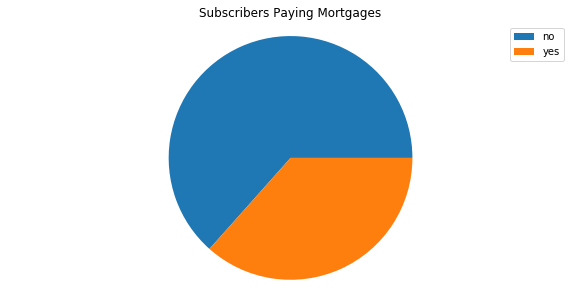

In [22]:
# pie chart of product subscribers by housing status
buyer_house_counts = pd.DataFrame(bank_marketing.loc[lambda df: df.y==
                    'yes','housing'].value_counts())
plt.figure(figsize=(10, 5))
plt.pie(buyer_house_counts)
plt.axis('equal')
plt.title('Subscribers Paying Mortgages')
plt.legend(buyer_house_counts.index)
plt.show()

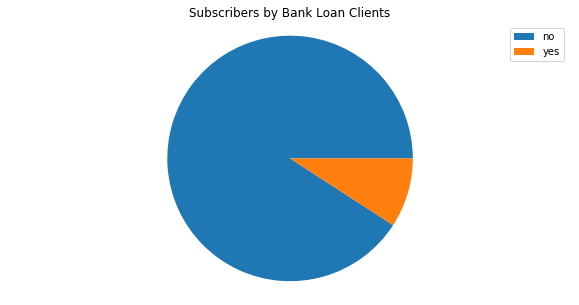

In [23]:
# pie chart of product subscribers by bank loan clients
buyer_loan_counts = pd.DataFrame(bank_marketing.loc[lambda df:
                    df.y=='yes','loan'].value_counts())
plt.figure(figsize=(10, 5))
plt.pie(buyer_loan_counts)
plt.axis('equal')
plt.title('Subscribers by Bank Loan Clients')
plt.legend(buyer_loan_counts.index)
plt.show()

initially surprising that the bank loan clients overwhelmingly haven't signed up.

## 3) Plot attributes related to contact with the clients

Analytic question 3
        line plot client contacts per month
        +pie chart contact type
        histogram of duration by age and balance

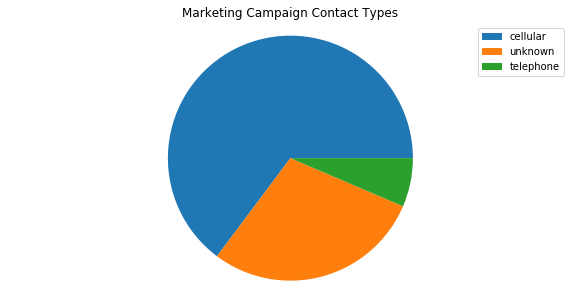

numpy.int64

In [97]:
plt.figure(figsize=(10, 5))
plt.pie(bank_marketing.contact.value_counts())
plt.axis('equal')
plt.title('Marketing Campaign Contact Types')
plt.legend(bank_marketing.contact.value_counts().index)
plt.show()
type()

In [109]:
# Here is where I wanted to plot the monthly duration of calls and the histogram
# of how many timees each age/bank account balance was contacted.
# Creating proper dates
print(bank_marketing.columns)
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5,
              'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10,
              'nov': 11, 'dec': 12}

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'year'],
      dtype='object')


# Further Research

During the 1st analytic question, I discussed the adherence of this data set to the oft reported trend that the elderly population is living longer a whole lot more than before, in aggregate.

This causes me to raise a question about the variance by age in deposits and employment status of these clients given my alegiance to the economic school of thought called Austrian Economics. Its origins are associated with the prominent figure and mentor of Ludwig von Mises during the time it was gaining global traction in the late 1800s. The central banks of today, such as the ... younger people needing to generate money for the old, but the old are now more employed than youth and can't retire as easily

This data was originally used with the goal to improve a specific marketing strategy, yet it can be used in economic analysis. The issues and economic indicators of savings rates and inflation dovetail into this study so gently, the former may already sit in the banks' databases and the latter was already integrated into the revision of this data set. I didn't choose to work with it because of the admissions that values were missing amongst the socioeconomic data added by the researchers. 

A question to get started on such work is - are the relevant client central tendencies and variances consistent over time during these marketing campgaigns? Small errors between the distributions should become a powerful foundation for integrating and reflecting developments over time in the reporting. Especially keep an eye out for redefinitions of macroeconomic key performance indicators!

# Citations

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014 [UCI ML Repo](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#)

[Paradox] Still need this citation